# **Environment Setup**

In [203]:
pip install -r requirements_pt1.txt

Note: you may need to restart the kernel to use updated packages.


In [204]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import Lasso
from sklearn.metrics import balanced_accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split

### Data Loading

In [205]:
hf_data_train_path = "data/heart_failure/train_val_split.csv"
hf_data_test_path = "data/heart_failure/test_split.csv"

In [206]:
df_train = pd.read_csv(hf_data_train_path)
df_test = pd.read_csv(hf_data_test_path)

### Data Exploration

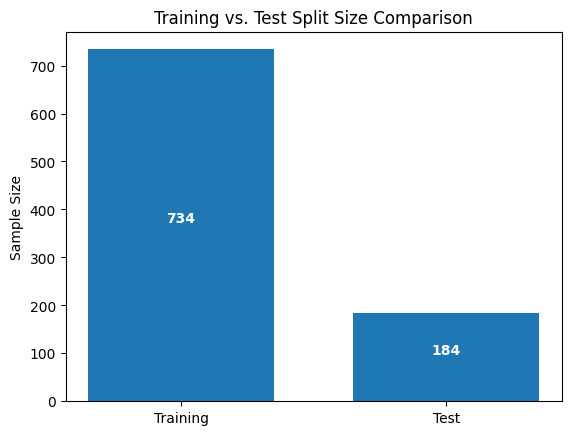

In [207]:
bars = plt.bar(["Training", "Test"], [len(df_train), len(df_test)], width=0.7)
plt.ylabel('Sample Size')
plt.title('Training vs. Test Split Size Comparison')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, round(yval, 2), va='bottom', color='w', weight="bold", horizontalalignment='center')

plt.show()

In [208]:
df_test.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,60,M,ASY,145,282,0,LVH,142,Y,2.8,Flat,1
1,57,M,ASY,160,0,1,Normal,98,Y,2.0,Flat,1
2,62,F,ASY,150,244,0,Normal,154,Y,1.4,Flat,1
3,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
4,57,M,ASY,128,0,1,ST,148,Y,1.0,Flat,1


In [209]:
df_test.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,53.461957,133.728261,203.630435,0.233696,139.369565,0.940761,0.597826
std,9.504021,18.080333,111.152602,0.424335,25.867344,1.002740,0.491675
min,28.000000,92.000000,0.000000,0.000000,71.000000,-2.600000,0.000000
25%,48.000000,120.000000,176.750000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,140.000000,1.000000,1.000000
75%,60.000000,145.250000,265.250000,0.000000,160.000000,1.600000,1.000000
max,75.000000,200.000000,603.000000,1.000000,202.000000,4.000000,1.000000


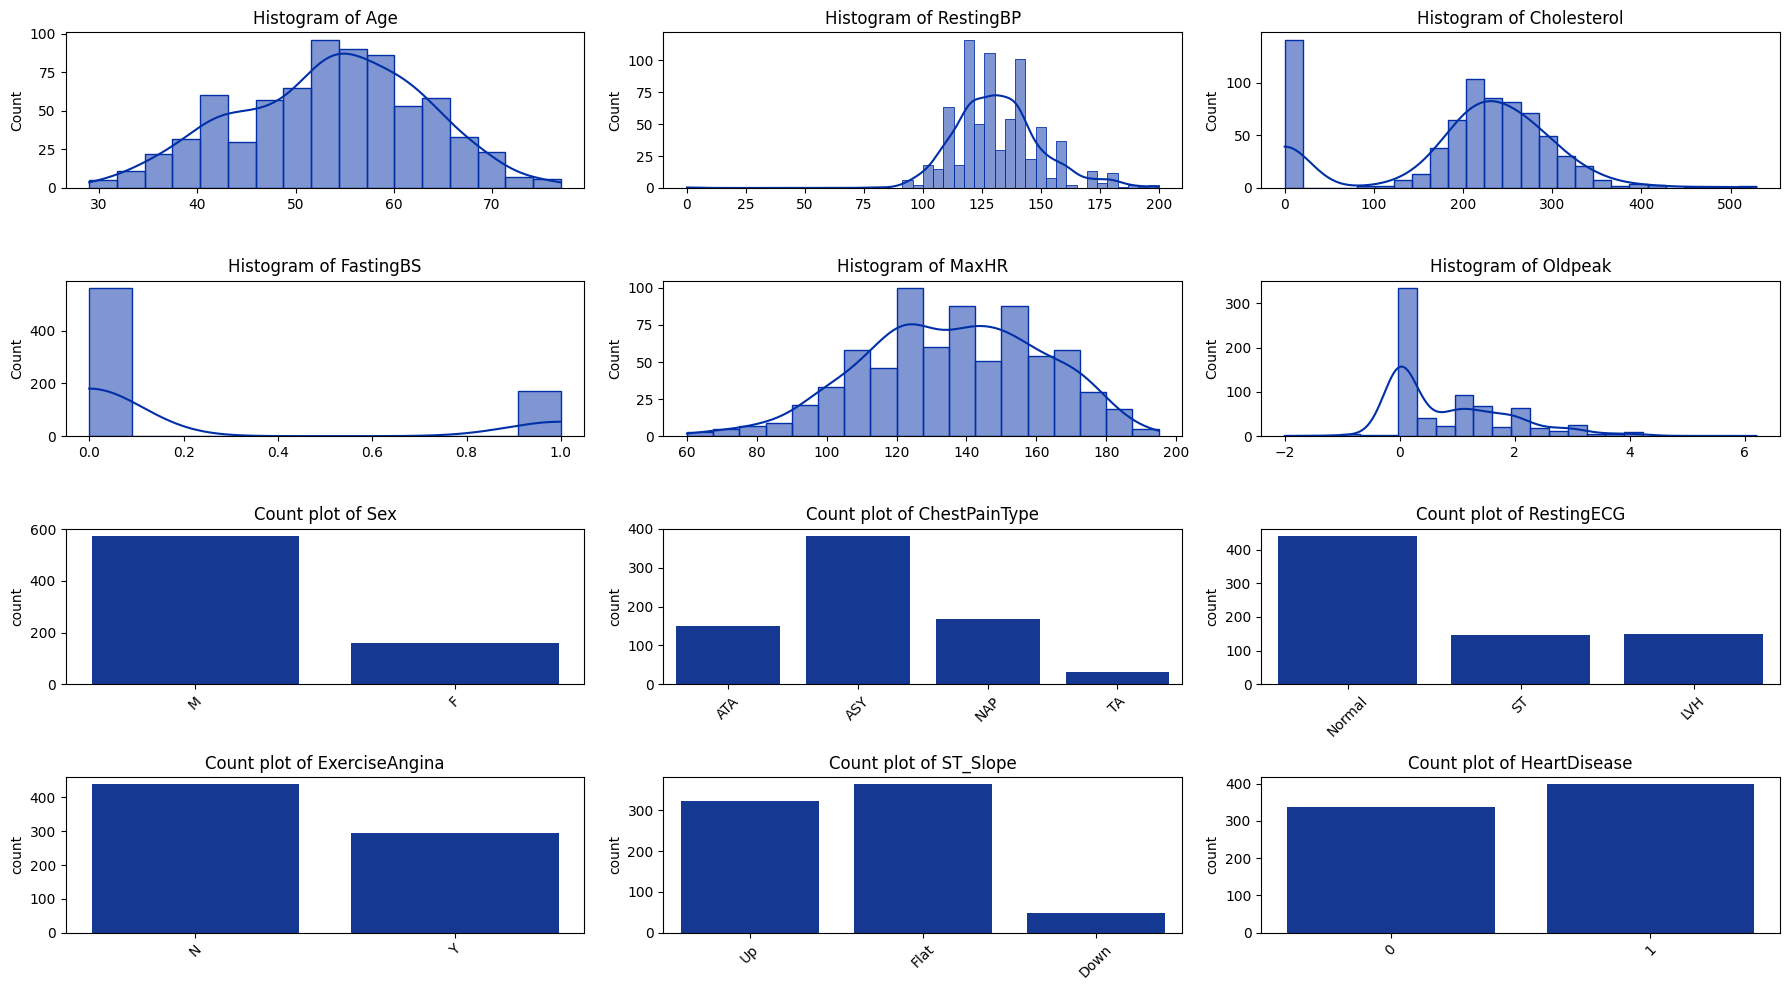

In [210]:
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).drop(columns=['HeartDisease'])
categorical_features = df_train.select_dtypes(include=['object'])

plt.figure(figsize=(18, 10))

for i, column in enumerate(numerical_features.columns):
    plt.subplot(4, 3, i + 1)
    sns.histplot(data=numerical_features[column], kde=True, color='#002fa7', edgecolor='#002fa7')
    plt.title(f'Histogram of {column}')
    plt.xlabel('')

for i, column in enumerate(categorical_features.columns):
    plt.subplot(4, 3, i + 1 + numerical_features.shape[1])
    sns.countplot(data=df_train, x=column, color='#002fa7')
    plt.title(f'Count plot of {column}')
    plt.xlabel('')
    plt.xticks(rotation=45)

plt.subplot(4, 3, 12)
sns.countplot(data=df_train, x='HeartDisease', color='#002fa7')
plt.title(f'Count plot of HeartDisease')
plt.xlabel('')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Cholesterol Level 0 

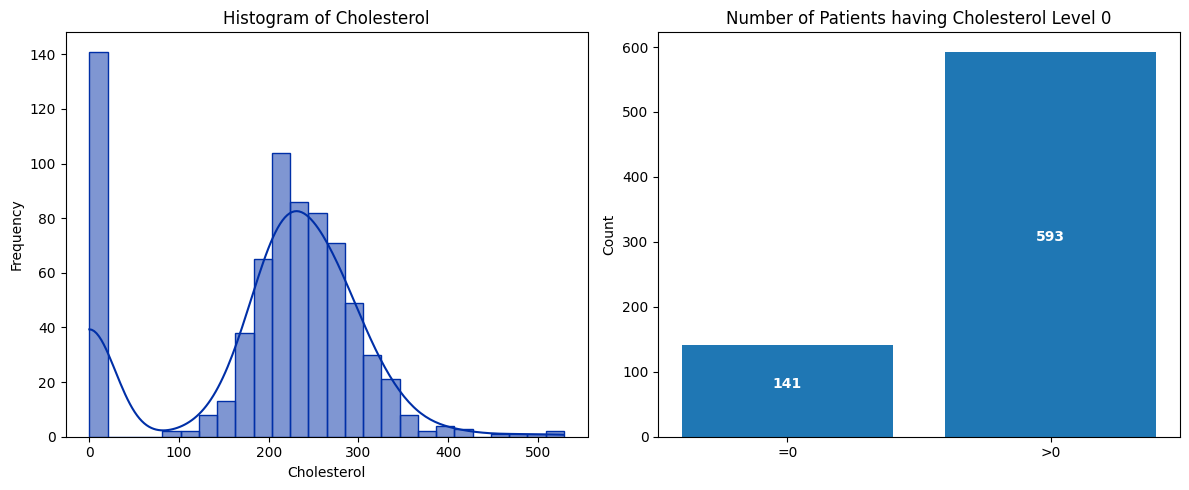

In [211]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df_train['Cholesterol'], kde=True, color='#002fa7', edgecolor='#002fa7', ax=axs[0])
axs[0].set_xlabel('Cholesterol')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Cholesterol')

greater_than_zero = (df_train['Cholesterol'] > 0).sum()
equal_to_zero = (df_train['Cholesterol'] == 0).sum()

bars = plt.bar(["=0", ">0"],[equal_to_zero, greater_than_zero])
axs[1].set_ylabel('Count')
axs[1].set_title('Number of Patients having Cholesterol Level 0')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval/2, round(yval, 2), va='bottom', color='w', weight="bold", horizontalalignment='center')

plt.tight_layout()

plt.show()

There are a bunch of patients that have cholesterol level 0 which seems like an NA (by googling it seems impossible to have 0 cholesterol).

In [212]:
print(pd.crosstab(df_train["Cholesterol"] != 0, df_train["HeartDisease"], normalize=True))

HeartDisease         0         1
Cholesterol                     
False         0.021798  0.170300
True          0.435967  0.371935


The data shows that the missing Cholesterol values are more prominent amongst the patients having a HeartDisease. Thus, they seem to not be missing at random, does it make sense to mean impute then?

#### Age-MaxHR Correlation

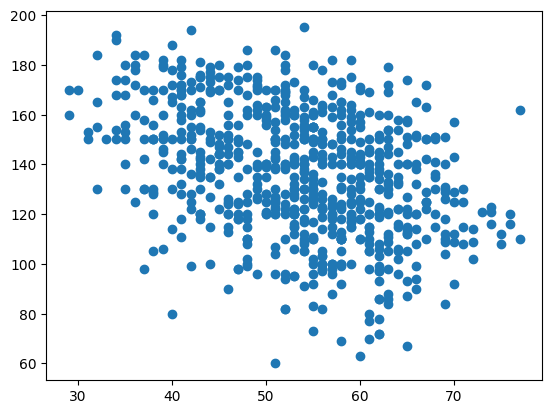

In [213]:
plt.scatter(df_train['Age'], df_train['MaxHR'])
plt.show()

#### Gender Imbalance

There is a big gender imbalance. Should we see if balancing the genders makes any difference or if gender has an impact in the data

In [214]:
print(pd.crosstab(df_train["Sex"], df_train["HeartDisease"], normalize=True))

HeartDisease         0         1
Sex                             
F             0.166213  0.053134
M             0.291553  0.489101


Should we maybe remove the Sex column?

# **Preprocess data**

We mean impute the missing values for Cholesterol.

In [215]:
mean_chol = np.mean(df_train.loc[df_train["Cholesterol"] != 0]['Cholesterol'])

df_train_imputed = df_train.copy(deep = True)
df_test_imputed = df_test.copy(deep = True)

df_train_imputed['Cholesterol'] = df_train_imputed['Cholesterol'].astype('float64')
df_test_imputed['Cholesterol'] = df_test_imputed['Cholesterol'].astype('float64')

df_train_imputed.loc[df_train['Cholesterol'] == 0, 'Cholesterol'] = mean_chol
df_test_imputed.loc[df_test['Cholesterol'] == 0, 'Cholesterol'] = mean_chol

We then apply a one hot encoding to the categorical variables and scale the numerical variables to adhere to a Standard Gaussian.

In [216]:
def preprocess_data(df, scaler):
  X = df.drop(columns=['HeartDisease'])
  y = df['HeartDisease']

  numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = X.select_dtypes(include=['object']).columns.tolist()

  X_num = pd.DataFrame(scaler.transform(X[numerical_features]), columns=numerical_features)
  X_cat = pd.get_dummies(X[categorical_features], drop_first=True, dtype=int)

  return pd.concat([X_num, X_cat],axis=1), y

In [217]:
numerical_features = df_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('HeartDisease')
categorical_features = df_test.select_dtypes(include=['object']).columns.tolist()

In the following we compare the performance of the models using the rescaled data with and without the mean imputed cholesteral.

In [218]:
scaler = StandardScaler().fit(df_train[numerical_features])
X_train, y_train = preprocess_data(df_train, scaler)
X_test, y_test = preprocess_data(df_test, scaler)

scaler_imputed = StandardScaler().fit(df_train_imputed[numerical_features])
X_train_imputed, y_train_imputed = preprocess_data(df_train_imputed, scaler_imputed)
X_test_imputed, y_test_imputed = preprocess_data(df_test_imputed, scaler_imputed)

In [219]:
X_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
count,7.340000e+02,7.340000e+02,7.340000e+02,7.340000e+02,7.340000e+02,7.340000e+02,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,-5.808251e-17,-4.573998e-16,-1.936084e-17,3.388147e-17,4.743405e-16,-1.936084e-17,0.780654,0.205722,0.230245,0.044959,0.599455,0.197548,0.401907,0.495913,0.438692
std,1.000682e+00,1.000682e+00,1.000682e+00,1.000682e+00,1.000682e+00,1.000682e+00,0.414086,0.404504,0.421277,0.207356,0.490343,0.398420,0.490618,0.500324,0.496565
min,-2.604776e+00,-7.097929e+00,-1.814317e+00,-5.511171e-01,-3.008520e+00,-2.657438e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.928705e-01,-6.483284e-01,-2.326662e-01,-5.511171e-01,-6.385982e-01,-8.081282e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.064843e-02,-1.108617e-01,2.241532e-01,-5.511171e-01,7.237841e-02,-3.458008e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.879504e-01,4.266051e-01,6.373567e-01,-5.511171e-01,7.438563e-01,5.788541e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2.493639e+00,3.651405e+00,3.043119e+00,1.814497e+00,2.323804e+00,4.924732e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


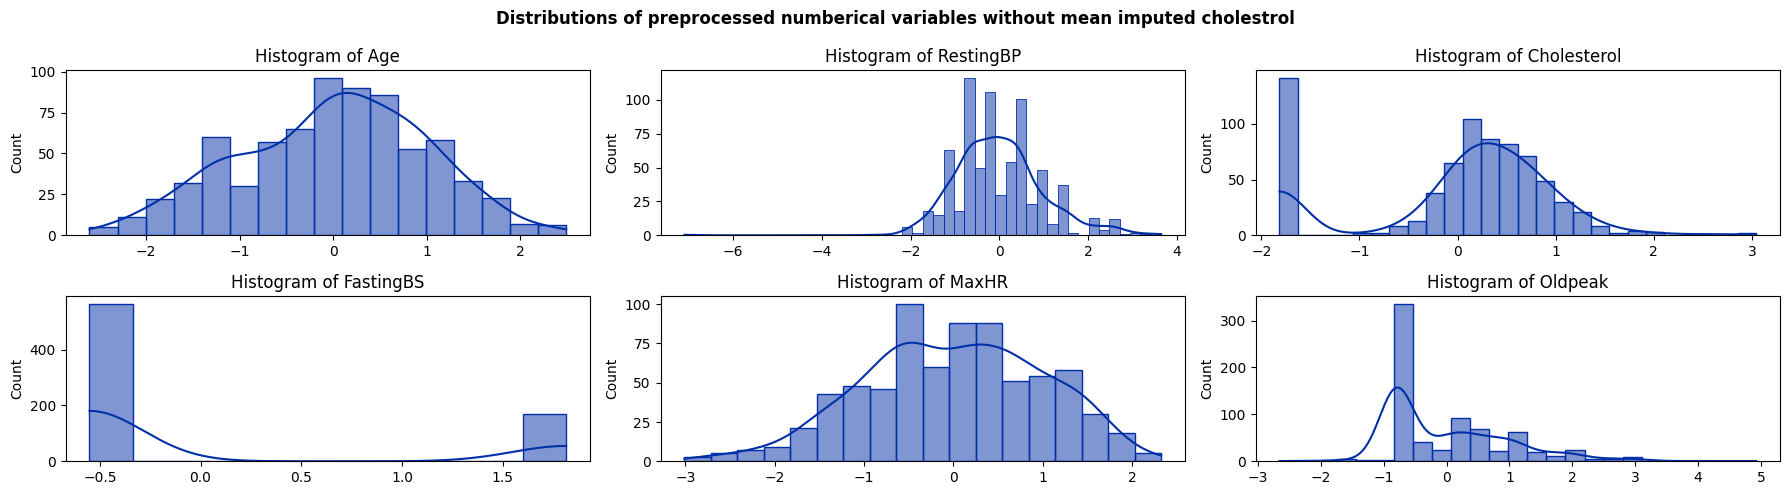

In [220]:
numerical_features = X_train.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(18, 5))

for i, column in enumerate(numerical_features.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=numerical_features[column], kde=True, color='#002fa7', edgecolor='#002fa7')
    plt.title(f'Histogram of {column}')
    plt.xlabel('')
    if i == 5:
        break

plt.suptitle("Distributions of preprocessed numberical variables without mean imputed cholestrol", weight="bold")
plt.tight_layout()
plt.show()

In [221]:
X_train_imputed.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
count,7.340000e+02,7.340000e+02,7.340000e+02,7.340000e+02,7.340000e+02,7.340000e+02,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,-5.808251e-17,-4.573998e-16,-3.339744e-16,3.388147e-17,4.743405e-16,-1.936084e-17,0.780654,0.205722,0.230245,0.044959,0.599455,0.197548,0.401907,0.495913,0.438692
std,1.000682e+00,1.000682e+00,1.000682e+00,1.000682e+00,1.000682e+00,1.000682e+00,0.414086,0.404504,0.421277,0.207356,0.490343,0.398420,0.490618,0.500324,0.496565
min,-2.604776e+00,-7.097929e+00,-3.143149e+00,-5.511171e-01,-3.008520e+00,-2.657438e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.928705e-01,-6.483284e-01,-5.972314e-01,-5.511171e-01,-6.385982e-01,-8.081282e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.064843e-02,-1.108617e-01,-5.598400e-16,-5.511171e-01,7.237841e-02,-3.458008e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,6.879504e-01,4.266051e-01,4.418179e-01,-5.511171e-01,7.438563e-01,5.788541e-01,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,2.493639e+00,3.651405e+00,5.602594e+00,1.814497e+00,2.323804e+00,4.924732e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


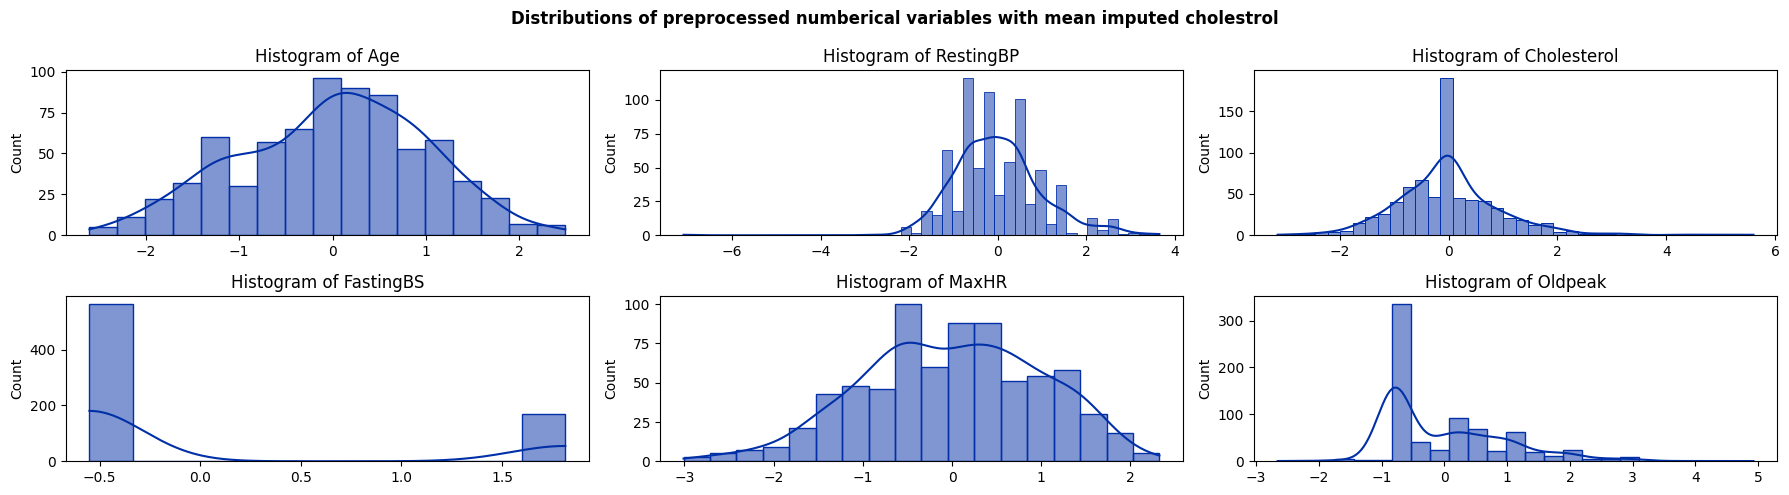

In [222]:
numerical_features = X_train_imputed.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(18, 5))

for i, column in enumerate(numerical_features.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data=numerical_features[column], kde=True, color='#002fa7', edgecolor='#002fa7')
    plt.title(f'Histogram of {column}')
    plt.xlabel('')
    if i == 5:
        break

plt.suptitle("Distributions of preprocessed numberical variables with mean imputed cholestrol", weight="bold")
plt.tight_layout()
plt.show()

# **Logistic Lasso Regression**

In [223]:
def train_logistic_lasso(X_train, y_train, X_test, y_test):
  logistic_lasso = LogisticRegression(penalty='l1', solver='liblinear')
  logistic_lasso.fit(X_train, y_train)

  y_pred_lasso = logistic_lasso.predict(X_test)

  acc_lasso = np.mean(y_test == y_pred_lasso)
  bas_lasso = balanced_accuracy_score(y_test, y_pred_lasso)
  f1s_lasso = f1_score(y_test, y_pred_lasso)

  print(f'Raw accuracy: {np.mean(y_pred_lasso == y_test)}')
  print("Balanced Accuracy Score:", bas_lasso)
  print("F1 Score:", f1s_lasso)

  for i, col in enumerate(X_train.columns):
    print(f'{col}: {logistic_lasso.coef_[0][i]}')

  return acc_lasso, bas_lasso, f1s_lasso, X_train.columns, logistic_lasso.coef_[0]

#### Without mean imputed cholestrol

In [224]:
_,_,_,cols,coef = train_logistic_lasso(X_train, y_train, X_test, y_test)

Raw accuracy: 0.8478260869565217
Balanced Accuracy Score: 0.8329238329238329
F1 Score: 0.8771929824561403
Age: 0.2371357725136042
RestingBP: 0.025414782793880406
Cholesterol: -0.44400797822456234
FastingBS: 0.37041454652904193
MaxHR: -0.085714415460465
Oldpeak: 0.44282006528744444
Sex_M: 1.450327799661779
ChestPainType_ATA: -1.9699859242218654
ChestPainType_NAP: -1.6555879380954865
ChestPainType_TA: -1.0031208849974964
RestingECG_Normal: -0.004543467989512132
RestingECG_ST: -0.14790184404992168
ExerciseAngina_Y: 0.8704613445403497
ST_Slope_Flat: 1.2252660672049474
ST_Slope_Up: -1.1369345458157973


We notice that the parameter for Cholesterol is negative, implying the probability of heart disease decreases with higher levels of cholesterol. That is quite unnatural, as high cholesterol is usually associated with health problems but not the reverse.

#### With mean imputed cholestrol

In [225]:
acc_lasso, bas_lasso, f1s_lasso,_,coef_imputed = train_logistic_lasso(X_train_imputed, y_train_imputed, X_test_imputed, y_test_imputed)

Raw accuracy: 0.8260869565217391
Balanced Accuracy Score: 0.8125307125307125
F1 Score: 0.8584070796460177
Age: 0.26923315763297845
RestingBP: -0.05408212241425084
Cholesterol: 0.18312237892756877
FastingBS: 0.45770484045912696
MaxHR: -0.18171269977875157
Oldpeak: 0.4185778853493064
Sex_M: 1.599341654367766
ChestPainType_ATA: -1.9956124292778246
ChestPainType_NAP: -1.5374893506579579
ChestPainType_TA: -1.04529122393898
RestingECG_Normal: 0.007145003317756551
RestingECG_ST: 0.0
ExerciseAngina_Y: 0.8353277191369587
ST_Slope_Flat: 1.011121107018039
ST_Slope_Up: -1.2601706577387444


Looking at the model parameters for the mean imputed cholesterol data, we get a more natural parameter for Cholesterol, a positive one. The obtained accuracy is slightly worse, but this feels like a more trustworthy model. Are there better ways to impute the Cholesterol? We could try using neural networks.

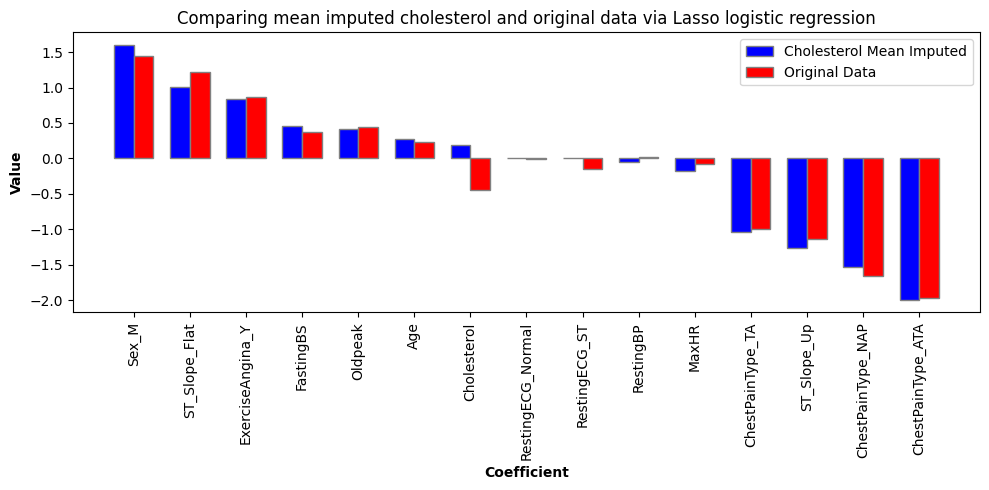

In [226]:
bar_width = 0.35

plt.figure(figsize=(10,5))

r1 = range(len(cols))
r2 = [x + bar_width for x in r1]

sorted_coef = np.flip(np.argsort(coef_imputed))

plt.bar(r1, coef_imputed[sorted_coef], color='b', width=bar_width, edgecolor='grey', label='Cholesterol Mean Imputed')
plt.bar(r2, coef[sorted_coef], color='r', width=bar_width, edgecolor='grey', label='Original Data')

plt.xlabel('Coefficient', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(cols))], cols[sorted_coef], rotation=90)
plt.ylabel('Value', fontweight='bold')
plt.title('Comparing mean imputed cholesterol and original data via Lasso logistic regression')
plt.legend()

plt.tight_layout()
plt.show()

# **Multi-Layer Perceptrons**

In [227]:
mlp = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester01/01PAI/Projects/task4_handout/exit/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [228]:
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = mlp.fit(X_train_imputed, y_train_imputed, epochs=20, batch_size=32)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5725 - loss: 0.6556
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7951 - loss: 0.5284
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8542 - loss: 0.4152
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8453 - loss: 0.3870
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8544 - loss: 0.3602
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8756 - loss: 0.3208
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8894 - loss: 0.2961
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8851 - loss: 0.3015
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8871 - loss: 0.2887
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8970 - loss: 0.2825
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8839 - loss: 0.2877
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8912 - lo

In [229]:
y_pred_mlp = mlp.predict(X_test_imputed)
y_pred_mlp = (y_pred_mlp > 0.5).astype(int)

acc_mlp = np.mean(y_test_imputed == y_pred_mlp.reshape(-1))
bas_mlp = balanced_accuracy_score(y_test_imputed, y_pred_mlp)
f1s_mlp = f1_score(y_test_imputed, y_pred_mlp)

print("Raw Accuracy:", acc_mlp)
print("Balanced Accuracy Score:", bas_mlp)
print("F1 Score:", f1s_mlp)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Raw Accuracy: 0.8260869565217391
Balanced Accuracy Score: 0.8103194103194102
F1 Score: 0.8596491228070176


In [230]:
negative_samples = X_train_imputed.loc[y_train_imputed == 0].sample(2, random_state = 42)
positive_samples = X_train_imputed.loc[y_train_imputed == 1].sample(2, random_state = 42)

In [231]:
explainer = shap.KernelExplainer(mlp, X_train_imputed.sample(50, random_state = 42))

neg_shap_values = explainer(negative_samples)
pos_shap_values = explainer(positive_samples)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  3.53it/s]


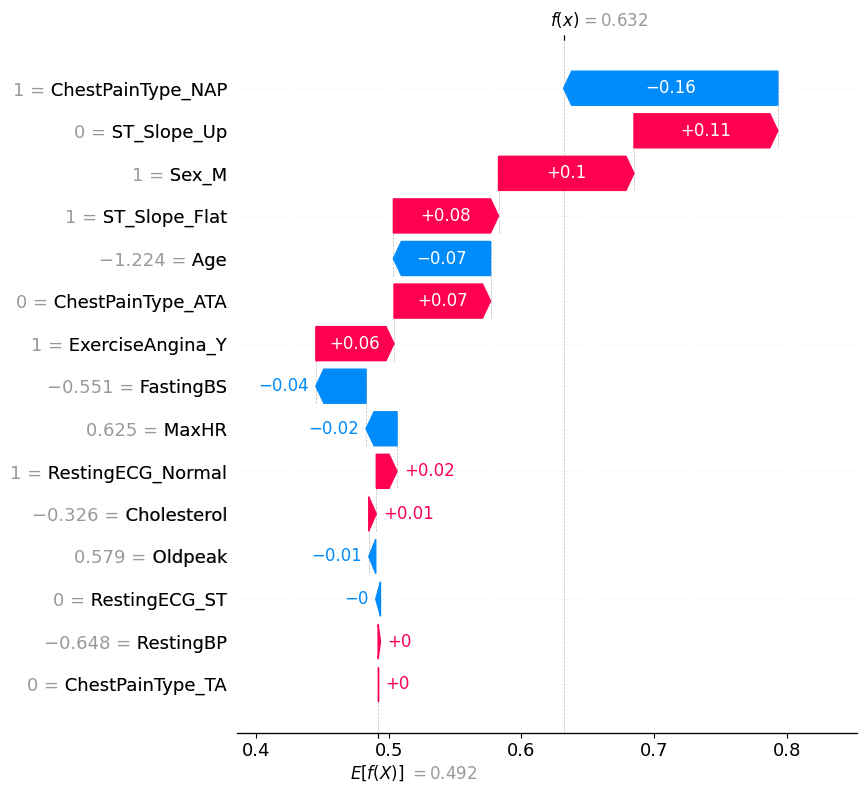

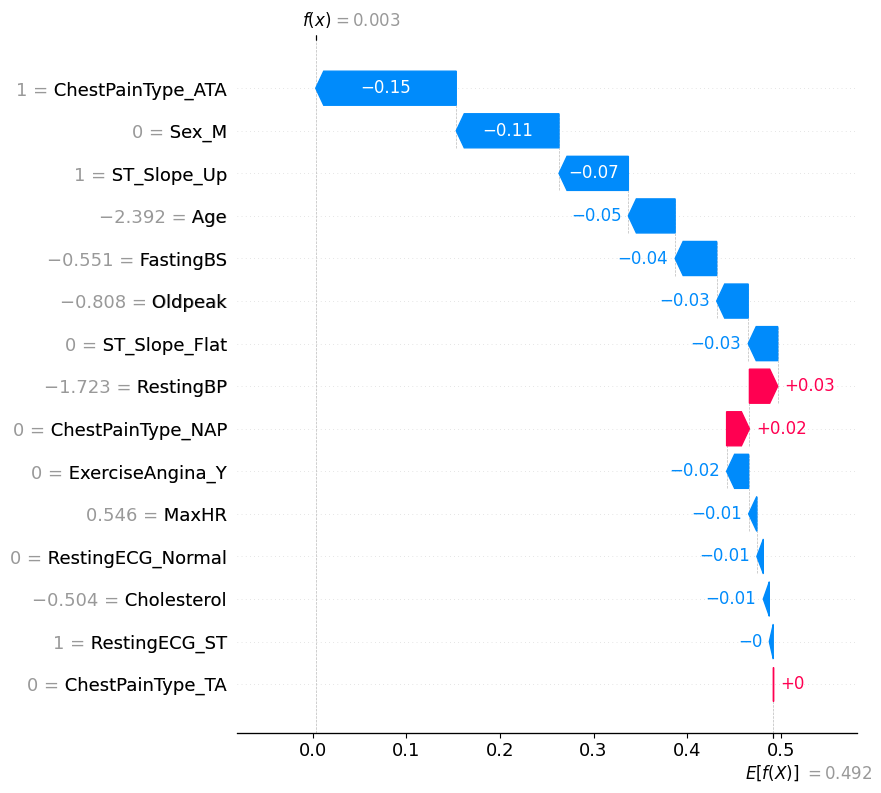

In [232]:
shap.plots.waterfall(neg_shap_values[0,:,0], max_display=20)
plt.show()

shap.plots.waterfall(neg_shap_values[1,:,0], max_display=20)
plt.show()

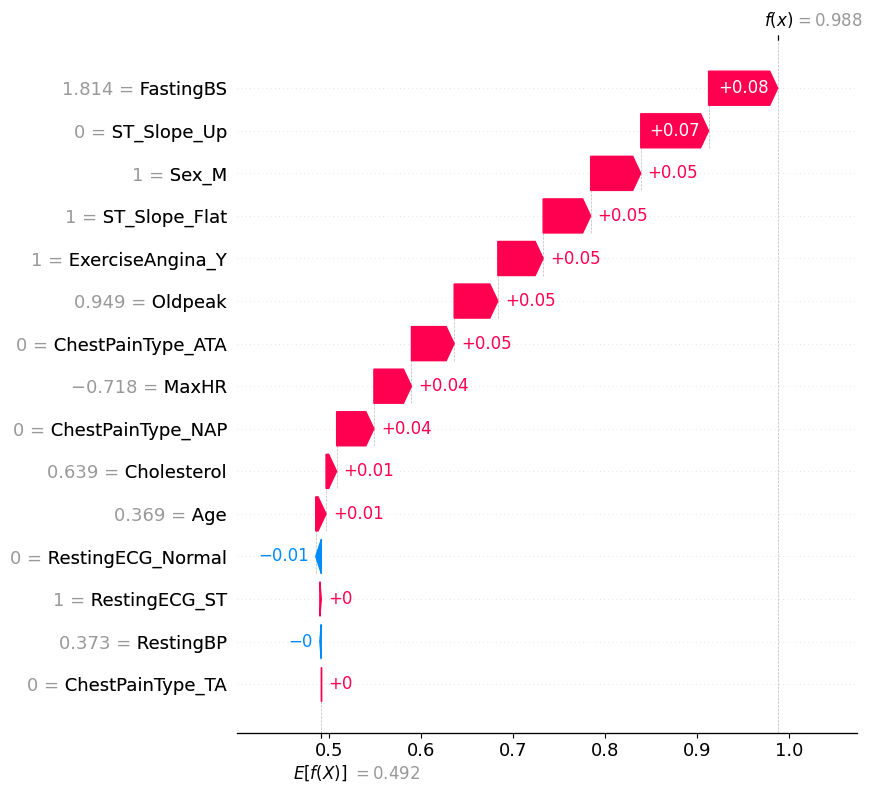

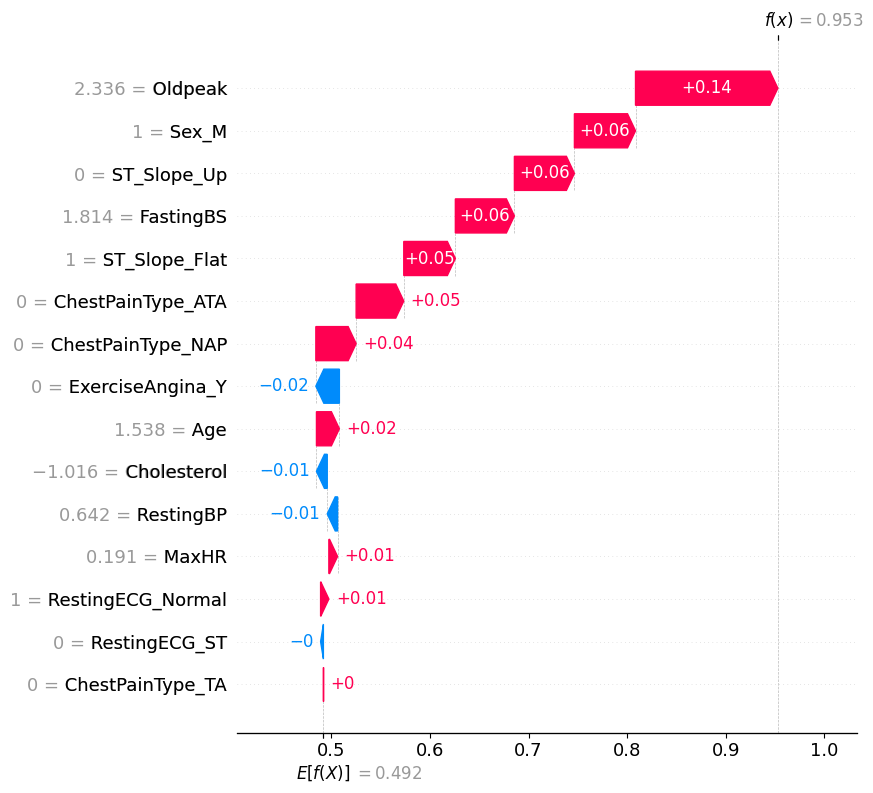

In [233]:
shap.plots.waterfall(pos_shap_values[0,:,0], max_display=20)
plt.show()

shap.plots.waterfall(pos_shap_values[1,:,0], max_display=20)
plt.show()

# **Neural Additive Model**


In [234]:
class NAMModel(nn.Module):
  def __init__(self, input_size):
    super(NAMModel, self).__init__()

    self.input_size = input_size
    model_list = []

    for i in range(input_size):
      model_list.append(nn.Sequential(
          nn.Linear(1, 20),
          nn.ReLU(),
          nn.Linear(20, 20),
          nn.Dropout(p=0.5),
          nn.ReLU(),
          nn.Linear(20,1)
      ))

    self.models = nn.ModuleList(model_list)
    self.bias = nn.Parameter(torch.zeros(1))
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    sum = 0

    for i in range(self.input_size):
      y = x[:,i].unsqueeze(1)
      y = self.models[i](y)
      sum += y

    return self.sigmoid(sum + self.bias).squeeze(1)

In [235]:
nam_torch = NAMModel(len(X_train.columns))

optimizer = optim.Adam(nam_torch.parameters(), lr=0.001)
criterion = nn.BCELoss()

X_train2, X_val, y_train2, y_val = train_test_split(X_train_imputed, y_train_imputed, test_size=0.1, random_state=42)

train_dataloader = DataLoader(torch.tensor(np.array(pd.concat((X_train2, y_train2), axis = 1)), dtype=torch.float32), batch_size=32, shuffle=True)
val_dataloader = DataLoader(torch.tensor(np.array(pd.concat((X_val, y_val), axis = 1)), dtype=torch.float32), batch_size=32)
test_dataloader = DataLoader(torch.tensor(np.array(pd.concat((X_test_imputed, y_test_imputed), axis = 1)), dtype=torch.float32), batch_size=32)

epochs = 160
losses = []
val_losses = []

pbar = tqdm(range(epochs))

best_loss = None

torch.manual_seed(42)

for epoch in pbar:
  epoch_loss = 0
  for batch in iter(train_dataloader):
    input, target = batch[:,:-1], batch[:,-1]

    optimizer.zero_grad()
    output = nam_torch(input)
    loss = criterion(output, target)
    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()

  val_loss = 0

  with torch.no_grad():
    for batch in iter(val_dataloader):
      input, target = batch[:,:-1], batch[:,-1]

      output = nam_torch(input)
      loss = criterion(output, target)
      val_loss += loss.item()

  if best_loss == None or val_loss < best_loss:
    torch.save(nam_torch.state_dict(), './best_model')

  val_losses.append(val_loss / len(val_dataloader))

  pbar.set_description(f"Epoch {epoch} train loss: {epoch_loss / len(train_dataloader)}, validation loss: {val_loss / len(val_dataloader)}")

  losses.append(epoch_loss / len(train_dataloader))

Epoch 159 train loss: 0.3202960462797256, validation loss: 0.36606041093667346: 


In [236]:
best_model = NAMModel(len(X_train.columns))
best_model.load_state_dict(torch.load('./best_model'))
best_model.eval()

NAMModel(
  (models): ModuleList(
    (0-14): 15 x Sequential(
      (0): Linear(in_features=1, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=20, bias=True)
      (3): Dropout(p=0.5, inplace=False)
      (4): ReLU()
      (5): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (sigmoid): Sigmoid()
)

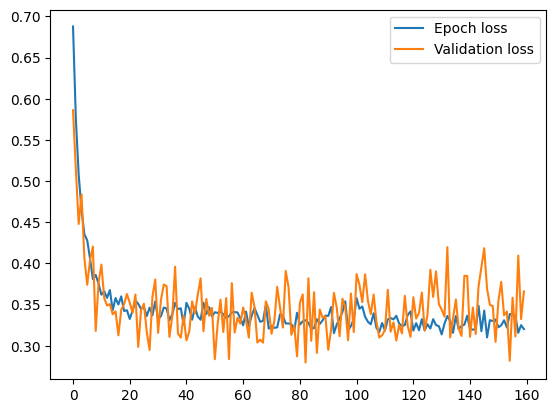

In [237]:
plt.plot(np.arange(epochs), losses, label="Epoch loss")
plt.plot(np.arange(epochs), val_losses, label="Validation loss")
plt.legend()
plt.show()

### Evaluation on test data

In [238]:
preds = []
gt = []
with torch.no_grad():
  for batch in iter(test_dataloader):
    input, target = batch[:,:-1], batch[:,-1]

    preds.append(nam_torch(input))
    gt.append(target)

preds_concated = np.array(torch.round(torch.cat(preds, axis=0)))
gt_concated = np.array(torch.cat(gt, axis = 0))

acc_nam = np.mean(preds_concated == gt_concated)
bas_nam = balanced_accuracy_score(gt_concated, preds_concated)
f1s_nam = f1_score(gt_concated, preds_concated)

print("Raw accuracy:", acc_nam)
print("Balanced Accuracy Score:", bas_nam)
print("F1 Score:", f1s_nam)

Raw accuracy: 0.8097826086956522
Balanced Accuracy Score: 0.8033169533169533
F1 Score: 0.8401826484018264


#### Explainability

### Feature importance

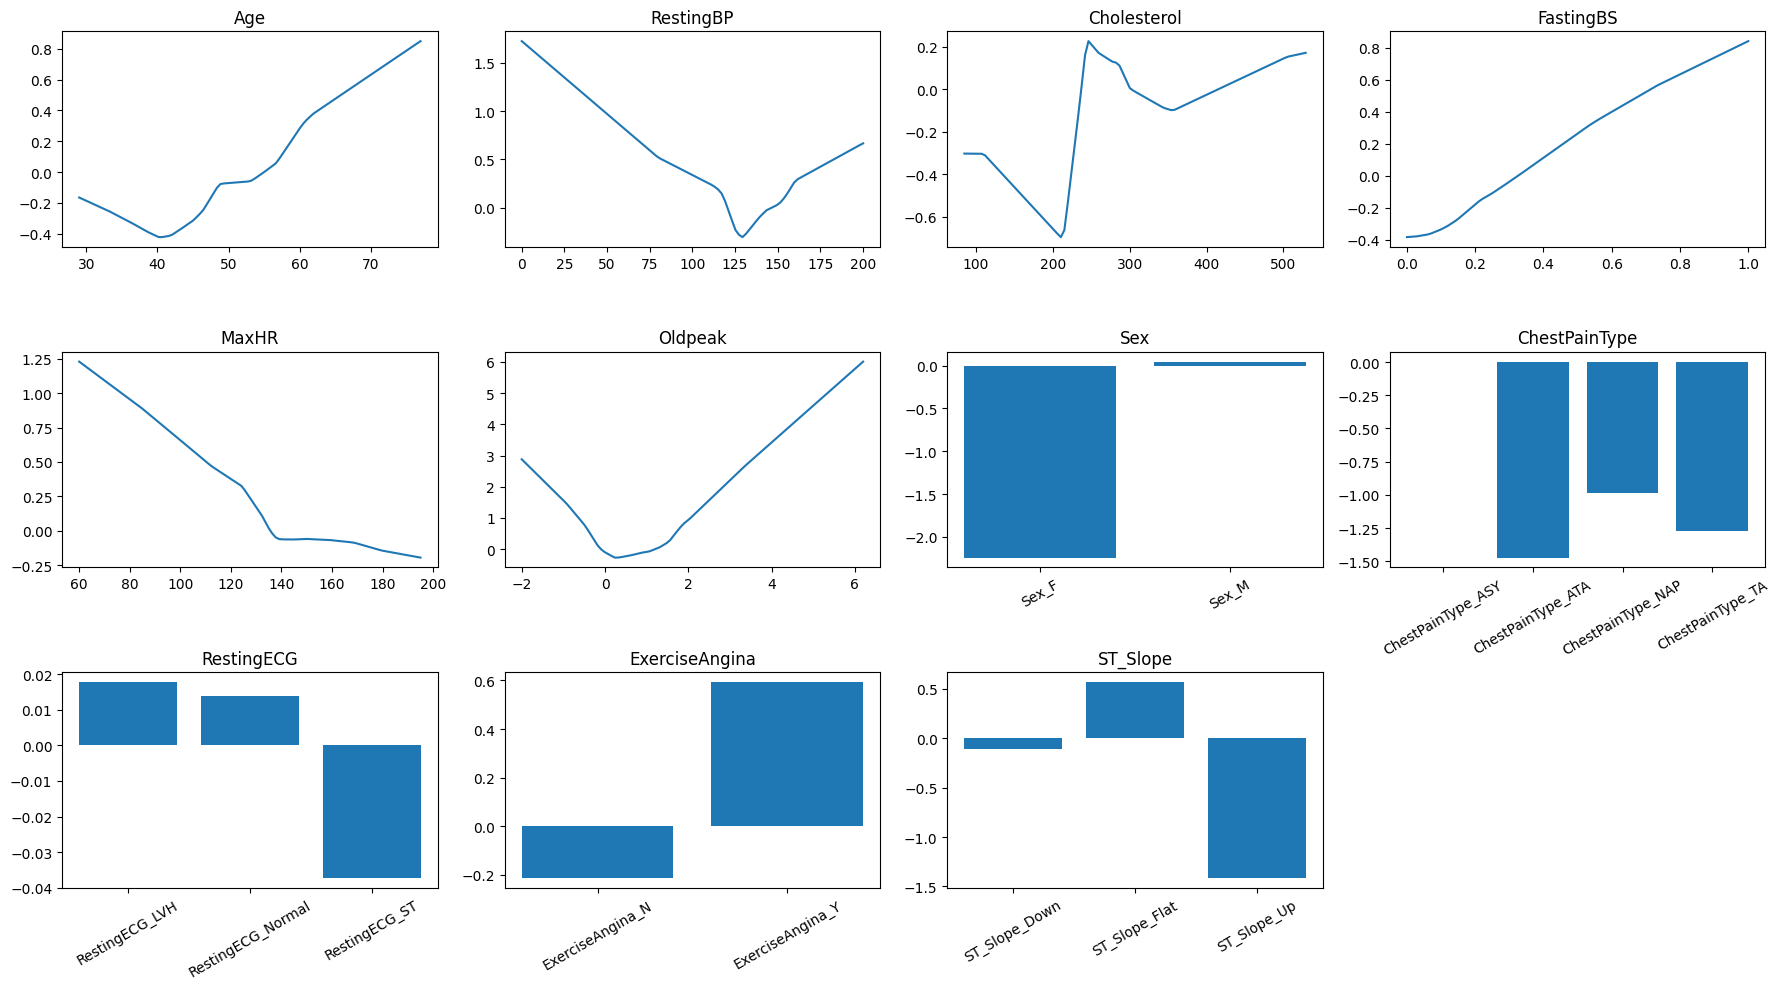

In [239]:
# Select numerical and categorical features
numerical_features = df_train_imputed.select_dtypes(include=['int64', 'float64'])
categorical_features = df_train_imputed.select_dtypes(include=['object'])

# Plot histograms for numerical features
plt.figure(figsize=(18, 10))

rolling_plot = 1
plotted_columns = []

for i, column in enumerate(X_train_imputed.columns):
  if column in numerical_features:
    plt.subplot(3, 4, rolling_plot)
    rolling_plot += 1

    col_values = X_train_imputed[column]

    values = np.linspace(min(col_values), max(col_values), 100)

    values_tensor = torch.tensor(values, dtype=torch.float32).unsqueeze(1)

    plt.title(column)
    plotted_columns.append(column)

    scaler_feature_index = np.where(scaler_imputed.feature_names_in_ == column)[0]

    with torch.no_grad():
      predictions = []
      for j in range(len(values_tensor)):
        torch.manual_seed(42)
        pred = nam_torch.models[i](values_tensor[j]).detach().numpy()
        predictions.append(pred)
      plt.plot(values * scaler_imputed.scale_[scaler_feature_index] + scaler_imputed.mean_[scaler_feature_index], predictions)
  else:
    # If a variable is categorical, we would like to compare each of the one hot encodings.
    # Example: ChestPainType has possibilities ASY, ATA, NAP, TA, where ASY gets one hot encoded
    # into (0,0,0), ATA -> (1,0,0), NAP -> (0,1,0), TA -> (0,0,1) (we skip the first column when one-hot encoding).
    corresponding_category = None

    for c in categorical_features:
      if c in column:
        corresponding_category = c

    if corresponding_category in plotted_columns:
      continue

    all_of_type = [f'{corresponding_category}_{sub_category}' for sub_category in np.unique(df_train_imputed[corresponding_category])]
    locs = [X_train.columns.get_loc(cat) if cat in X_train_imputed.columns else None for cat in all_of_type]

    sums = []

    for i in range(len(all_of_type)):
      sum = 0
      for loc in locs:
        if loc == None:
          continue
        if loc == locs[i]:
          sum += nam_torch.models[loc](torch.ones(1))
        else:
          sum += nam_torch.models[loc](torch.zeros(1))

      sums.append(sum.detach().numpy()[0])

    plt.subplot(3, 4, rolling_plot)

    plt.bar(all_of_type, sums)
    plt.title(corresponding_category)
    plt.xticks(rotation=30)
    plotted_columns.append(corresponding_category)

    rolling_plot += 1

plt.tight_layout()
plt.show()

# **Model Comparison**

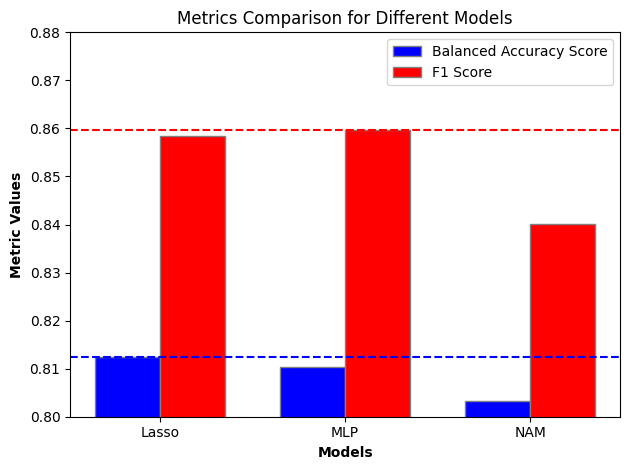

In [240]:
models = ['Lasso', 'MLP', 'NAM']
bas_values = [bas_lasso, bas_mlp, bas_nam]
f1s_values = [f1s_lasso, f1s_mlp, f1s_nam]

bar_width = 0.35

r1 = range(len(models))
r2 = [x + bar_width for x in r1]

plt.bar(r1, bas_values, color='b', width=bar_width, edgecolor='grey', label='Balanced Accuracy Score')
plt.bar(r2, f1s_values, color='r', width=bar_width, edgecolor='grey', label='F1 Score')

plt.ylim(0.8, 0.88)
plt.axhline(y=max(bas_values), color='b', linestyle='--')
plt.axhline(y=max(f1s_values), color='r', linestyle='--')
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(models))], models)
plt.ylabel('Metric Values', fontweight='bold')
plt.title('Metrics Comparison for Different Models')
plt.legend()

plt.tight_layout()
plt.show()

# **TODO**

- NAM does not perform as described in report (lowest BAC)
- need to clean notebook to make it easily readible
    - delete unncessary imports and code snippets 
    - add some more descriptions 
- add descripton ro run notebook to README
- complete reaquirements_pt1.txt